# <u>**Lab 4: 3D Reconstruction from two images with known internal parameters</u>**

In this lab you will learn how to triangulate the matching correspondences between two views of the same scene, by means of applying the Direct Linear Method (DLT). Then you will compute the camera matrices of these images given the Fundamental Matrix and the Intrinsic Matrix, and will evaluate your triangulation method on these camera matrices by estimating the reprojection error in the triangulation. 

The last two tasks will involve the computation of depth maps by local methods (SSD, NCC), with their evaluation, and the implementation of bilateral weights on this mapping. 

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [2]:
from IPython.display import display, HTML
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (19, 10)
from operator import itemgetter
from plotly import graph_objects as go
import copy
from tqdm import tqdm
from multiprocessing import Pool
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from time import time 
from functools import partial

import utils
from utils import homogeneous2euclidean, euclidean2homogeneous, projective2img, img2projective
import aux_code as aux

np.set_printoptions(precision=3)

# **1. Triangulation with the DLT method**

The first task is to implement the DLT method that will compute the 3D points corresponding to the matches of two images whose camera matrices are known. [See derivation of DLT here](https://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf)

![image](https://user-images.githubusercontent.com/8356912/151347636-c3332917-a7da-402e-9eb6-f39beb91591a.png)


<span style='color:Green'> - Create the function triangulate(x1, x2, P1, P2, imsize) that performs a triangulation with the homogeneous algebraic method (DLT)  </span>

The entries are (x1, x2, P1, P2, imsize), where:
- x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
- x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
- P1: Camera 1 matrix of shape (3,4)
- P2: Camera 2 matrix of shape (3,4)
- imsize: Iterable with shape (2,) with the image size

The function should return:
- X: array of shape (4, `n_points`), containing the Homogenous Coordinates of the points in 3D space.  

Test the triangulate function: use this code to validate that the function triangulate works properly

HINT: check numpy.linalg.svd

In [3]:
# Write here the method for DLT triangulation
def triangulate(x1, x2, P1, P2, imsize) -> np.ndarray:
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3
    
    nx = imsize[0]
    ny = imsize[1]
    
    # Convert to cartesian coordinates
    x1 = x1 / x1[2,:]
    x2 = x2 / x2[2,:]
    
    # Construct H matrix
    H = [[2/nx,0,-1],
         [0,2/ny,-1],
         [0,0,1]]
    
    # We build A from ...
    x1 = H@x1
    x2 = H@x2
    P1 = H@P1
    P2 = H@P2
    
    X = np.zeros((4,x1.shape[1]))
    
    # We build different A's for each point
    for i in range(x1.shape[1]):
        x = x1[0,i]
        y = x1[1,i]
        x_prime = x2[0,i]
        y_prime = x2[1,i]
        A = [x*P1[2,:].T - P1[0,:].T, y*P1[2,:].T - P1[1,:].T, x_prime*P2[2,:].T - P2[0,:].T, y_prime*P2[2,:].T - P2[1,:].T]
        
        U,D,V = np.linalg.svd(A)
        V = V.T
        X[:,i] = V[:,-1] 
        
    
    return X
    

#### Test the triangulation function with two Cameras and some random points. The average triangulation error should be lower than 10<sup>-8</sup>


In [4]:
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1                            # Cam1 Canonical Camera Matrix

angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])     # Cam2 Rotation_z(theta[deg])
t = np.array([[1.1, .1, .2]])                         # Cam2 Translation(x[m], y[m], z[m]) 
P2 = np.concatenate((R, t.T), axis=1)

n_points = 20                                        # Number of data samples (points) (x,y,z)
X_eucl = np.random.uniform(0, 1, (3,n_points))       # Random points in 3D space on world reference frame
X_eucl[2,:] += 3                                     # Make points fit into the camera frame 
X = euclidean2homogeneous(X_eucl)                    # 

# Obtain the camera coordinates (rays) from each point.
x_proj1 = P1 @ X                                     # Project to Cam1 image coordinates (x,y,z)->[x_c1:y_c1:z_c1]
x_proj2 = P2 @ X                                     # Project to Cam2 image coordinates (x,y,z)->[x_c2:y_c2:z_c2]

# Estimate the 3D points (you need to create this function)
X_trian = triangulate(x_proj1, x_proj2, P1, P2, ((2,2)));
assert X_trian.shape == (4, n_points)

# Evaluation: compute the reprojection error
X_eucl_pred = homogeneous2euclidean(X_trian)
X_eucl = homogeneous2euclidean(X)
errors = np.linalg.norm(X_eucl - X_eucl_pred, axis=0)
avg_error = np.mean(errors)
print(f"Average triangulation error: {avg_error:.2e}[m]")
assert avg_error < 1e-8, "Something might be wrong here"


Average triangulation error: 1.50e-15[m]


#### We will plot the results to check that the triangulated values are close to the ground truth

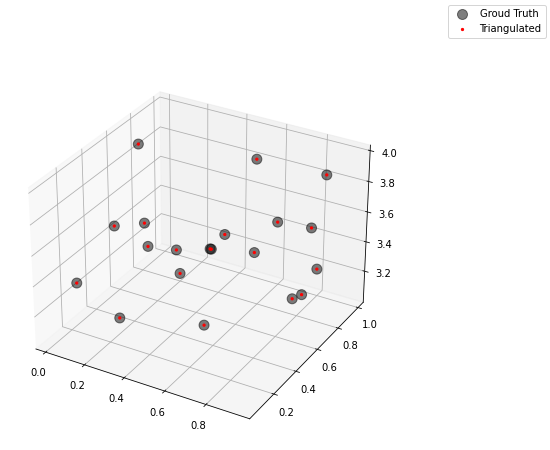

In [5]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
utils.draw_points(X_eucl.T, ax=ax, c="k", alpha=0.5, s=100, depthshade=True, label="Groud Truth")
utils.draw_points(X_eucl_pred.T, ax=ax, c="r", alpha=1, s=5, depthshade=True, label="Triangulated")
fig.legend()

In [6]:
fig = go.Figure(layout=dict(height=400, width=550))
fig.add_trace(go.Scatter3d(x=X_eucl[0,:], y=X_eucl[1,:], z=X_eucl[2,:], mode='markers', marker=dict(size=6, color="black", opacity=0.5), name='Ground Truth'))
fig.add_trace(go.Scatter3d(x=X_eucl_pred[0,:], y=X_eucl_pred[1,:], z=X_eucl_pred[2,:], mode='markers', marker=dict(size=2, color="red", opacity=1), name='Triangulated'))
fig.show()

# 2. **[Reconstruction](https://www.cs.cmu.edu/~16385/s17/Slides/12.5_Reconstruction.pdf) from two views**

The goal of this section is to estimate the 3D reconstruction from two views in a practical situation where the image correspondences contain outliers. 

To acomplish this you have to:

1. Find a set of point correspondences between the two images. This correspondences will contain noise/outliers, therefore we cannot use [Epipolar Geometry](https://www.cs.cmu.edu/~16385/s17/Slides/12.1_Epipolar_Geometry.pdf) to calculate the [Essential Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf), but we can find the Fundamental Matrix. 
2. Estimate the [Fundamental Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.3_Fundamental_Matrix.pdf) relating the two camera images. Since correspondances are noisy we will use the [8-point Algorithm](https://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf) in combination with the RANSAC algorithm, to find a good estimate of $F$.
3. Calculate the Essential Matrix from the Fundamental Matrix
4. Find the two Camera Matrices.
## 2.1 Estimate the image matches


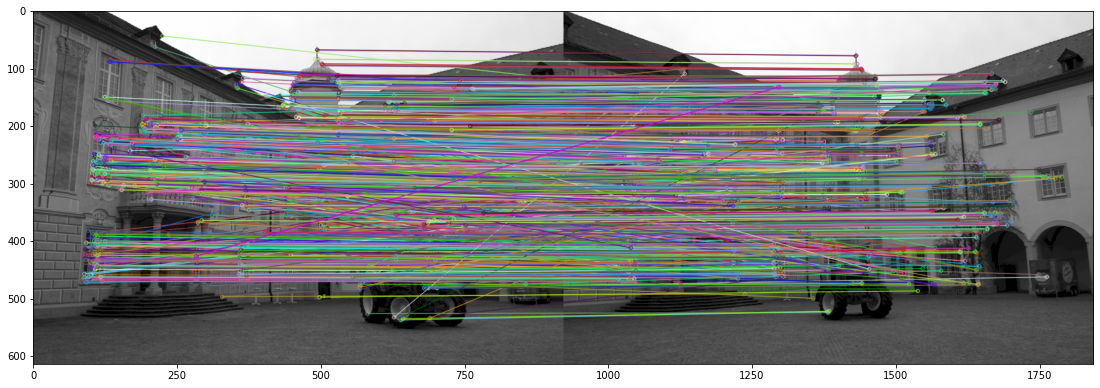

In [7]:
# Read images
img1 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0002_s.png',cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

## 2.2 Estimate the Fundamental Matrix
To find the Fundamental Matrix $F$ we will use the 8-point algorithm. However, using only 8 correspondances might lead to bad estimates of $F$. To find a robust estimate we will use the RANSAC algorithm. In simple words the algorithm samples randomly 8 correspondances and estimates $F_{estimated}$ for these samples, then it evaluates how well does $F_{estimated}$ fit the rest of the data. We repreat this process until a limit of iterations is reached and select the best estimated $F$.  

(Code is provided)

1770 680


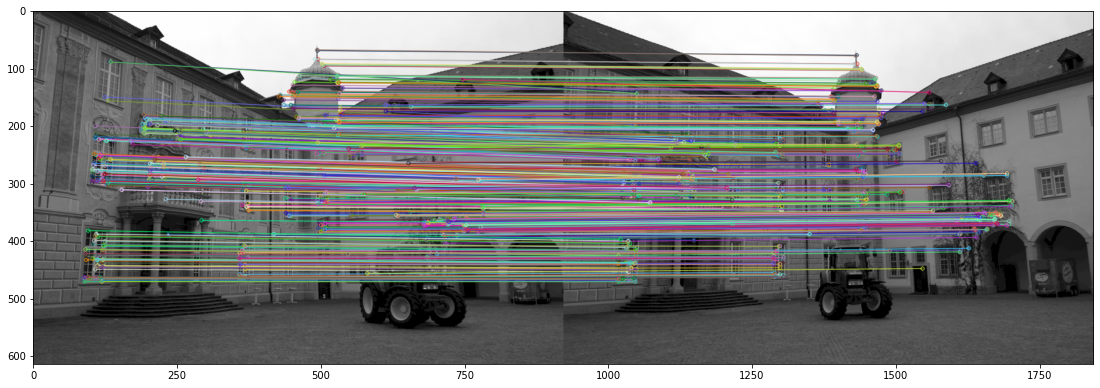

In [8]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = aux.Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

## 2.3 Estimate the Essential Matrix
<span style='color:Green'> - Compute the [Essential matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf) from the Fundamental matrix </span>

In [9]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K

def essential_from_fundamental(K, F):
    E = K.T@F@K
    return E

E = essential_from_fundamental(K, F)

## 2.4. Estimate the Camera Matrices from the Essential Matrix
<span style='color:Green'> - Estimate the camera projection matrices. Assuming the first Camera has a cannonical matrix you will obtain four possible Camera Matrices for the second camera, two rotations and two translations.</span>

 - Please explain how do you obtain this estimates, not what algorithm or methodology you used to obtain them. i.e., What system of equations are you solving?
 - Why do you obtain 4 solutions? Why not only one?

HINT: Once you estimate the rotations $R$ and translation $T$ of the second camera matrix, you may get as results improper rotations: $|R| = -1$ i.e., $R \in O(3), R \notin SO(3)$. <span style='color:Green'> (Why do you think this happens?) </span> In that case you should make the rotation proper by avoiding the unwanted reflexion (multiply by -1 so $|R| = 1$): e.g.,
  
      if det(R) < 0:  
          R = -R

In [10]:
# # camera projection matrix for the first camera
# We use the camera calibration matrix
P1 = K @ np.hstack((np.identity((3)), np.zeros((1,3)).T))

# # four possible matrices for the second camera
Pc2 = [None, None, None, None]
W = np.array([[0,-1,0],
     [1,0,0],
     [0,0,1]])
U,D,V_T = np.linalg.svd(E) 

R1 = U@W@V_T
R2 = U@W.T@V_T

if np.linalg.det(R1) < 0:
     R1 = -R1
if np.linalg.det(R2) < 0:
     R2 = -R2
     
Pc2[0] = K @ np.hstack((R1, np.array([U[:,-1]]).T))
Pc2[1] = K @ np.hstack((R1, -np.array([U[:,-1]]).T))
Pc2[2] = K @ np.hstack((R2, np.array([U[:,-1]]).T))
Pc2[3] = K @np.hstack((R2, -np.array([U[:,-1]]).T))

# Absolute value more or less of 1
print(np.linalg.det(R1))
print(np.linalg.det(R2))

0.9999999999999999
0.9999999999999999


Lets visualize the 4 possible Camera positions and orientations, in relation to Camera 1 

(-1.5, 1.5)

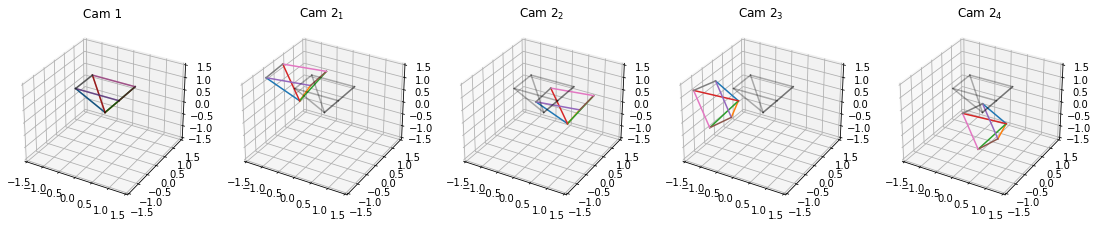

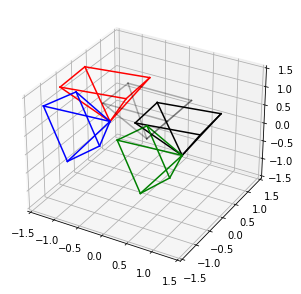

In [11]:
# plot the first camera and the four possible solutions for the second figure:
fig = plt.figure()
axs = [fig.add_subplot(1,5,i+1, projection='3d') for i in range(5)]
titles = ["Cam 1"] + [r"Cam $2_{%s}$" % int(i+1) for i in range(len(Pc2)) ]

low_lim, up_lim = -1.5, 1.5
for ax, title, P in zip(axs, titles, [P1] + Pc2):
    utils.plot_camera(P,w,h, 1, ax=ax)
    utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
    ax.set_title(title)
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
for P, color in zip(Pc2, ['r','k','b','g']):
    utils.plot_camera(P,w,h, 1, ax=ax, color=color)
utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
ax.set_xlim(low_lim, up_lim)
ax.set_ylim(low_lim, up_lim)
ax.set_zlim(low_lim, up_lim)

<span style='color:Green'> - Triangulate the correspondances and select the "optimal" camera, how do you select it ?</span>
   

Cam 2_1 selected


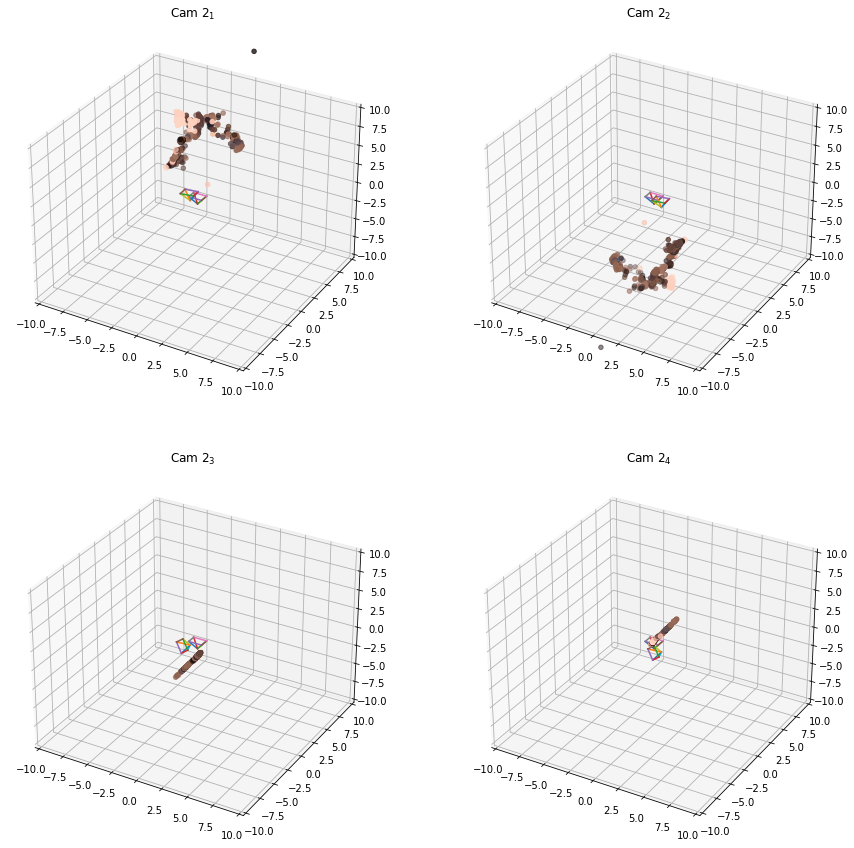

In [17]:
# A reconstructed point x will be in front of both cameras in one of these four solutions only

img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_UNCHANGED)


# Obtain the inlier points projective coordinates for Camera 1 and 2 
x1 = points1[:,indices_inlier_matches]
x2 = points2[:,indices_inlier_matches]

# Prepare figure 
fig = plt.figure(figsize=(15,15))
axs = [fig.add_subplot(2,2,i+1, projection='3d') for i in range(4)]

# Variable for optimal camera
P2_selected = None

low_lim, up_lim = -10, 10
for i, ax, P2 in zip(range(len(Pc2)), axs, Pc2):
    # Estimate by triangulization the 3D coordinates of the matches
    X_pred = triangulate(x1, x2, P1, P2, [w, h])
    X_eucl = homogeneous2euclidean(X_pred)
    
    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (img1[x_img[:,1], x_img[:,0]])/255
    utils.draw_points(X_eucl.T, color=rgb_txt, ax=ax)
    utils.plot_camera(P1,w,h,1, ax=ax)
    utils.plot_camera(P2,w,h,1, ax=ax)
    ax.set_title(r"Cam $2_{%d}$" % (i+1))
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    # ax.view_init(0, 15)

    
    # Normalize x
    x = X_pred[:,1]
    x = x / x[3]
    
    # Select the best camera using some metric 
    x_hat_p1 = P1@x
    x_hat_p2 = P2@x
    
    # Source: https://stackoverflow.com/questions/9796077/determining-if-a-3d-point-is-in-front-of-a-pair-of-stereo-camera-given-their-es
    # Both camera predictions must be in front of the camera, looking toward the z direction. So, if predicted z is positive
    # for camera 1 => point in front of camera 1. Similar method to camera 2.
    
    if x_hat_p1[2] > 0 and x_hat_p2[2] > 0:
        print('Cam 2_%d selected' %(i+1))
        P2_selected = P2

# From now own P2 will be the camera you selected
P2 = P2_selected

# Visualize just the selected camera

## 2.5 3D Visualization
 We will visualize the 3D points for the selected camera with an interactive plot so that you can see the surfaces reconstructed in 3D

In [18]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()


In [13]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
#### And these are the corresponding points in 2D 

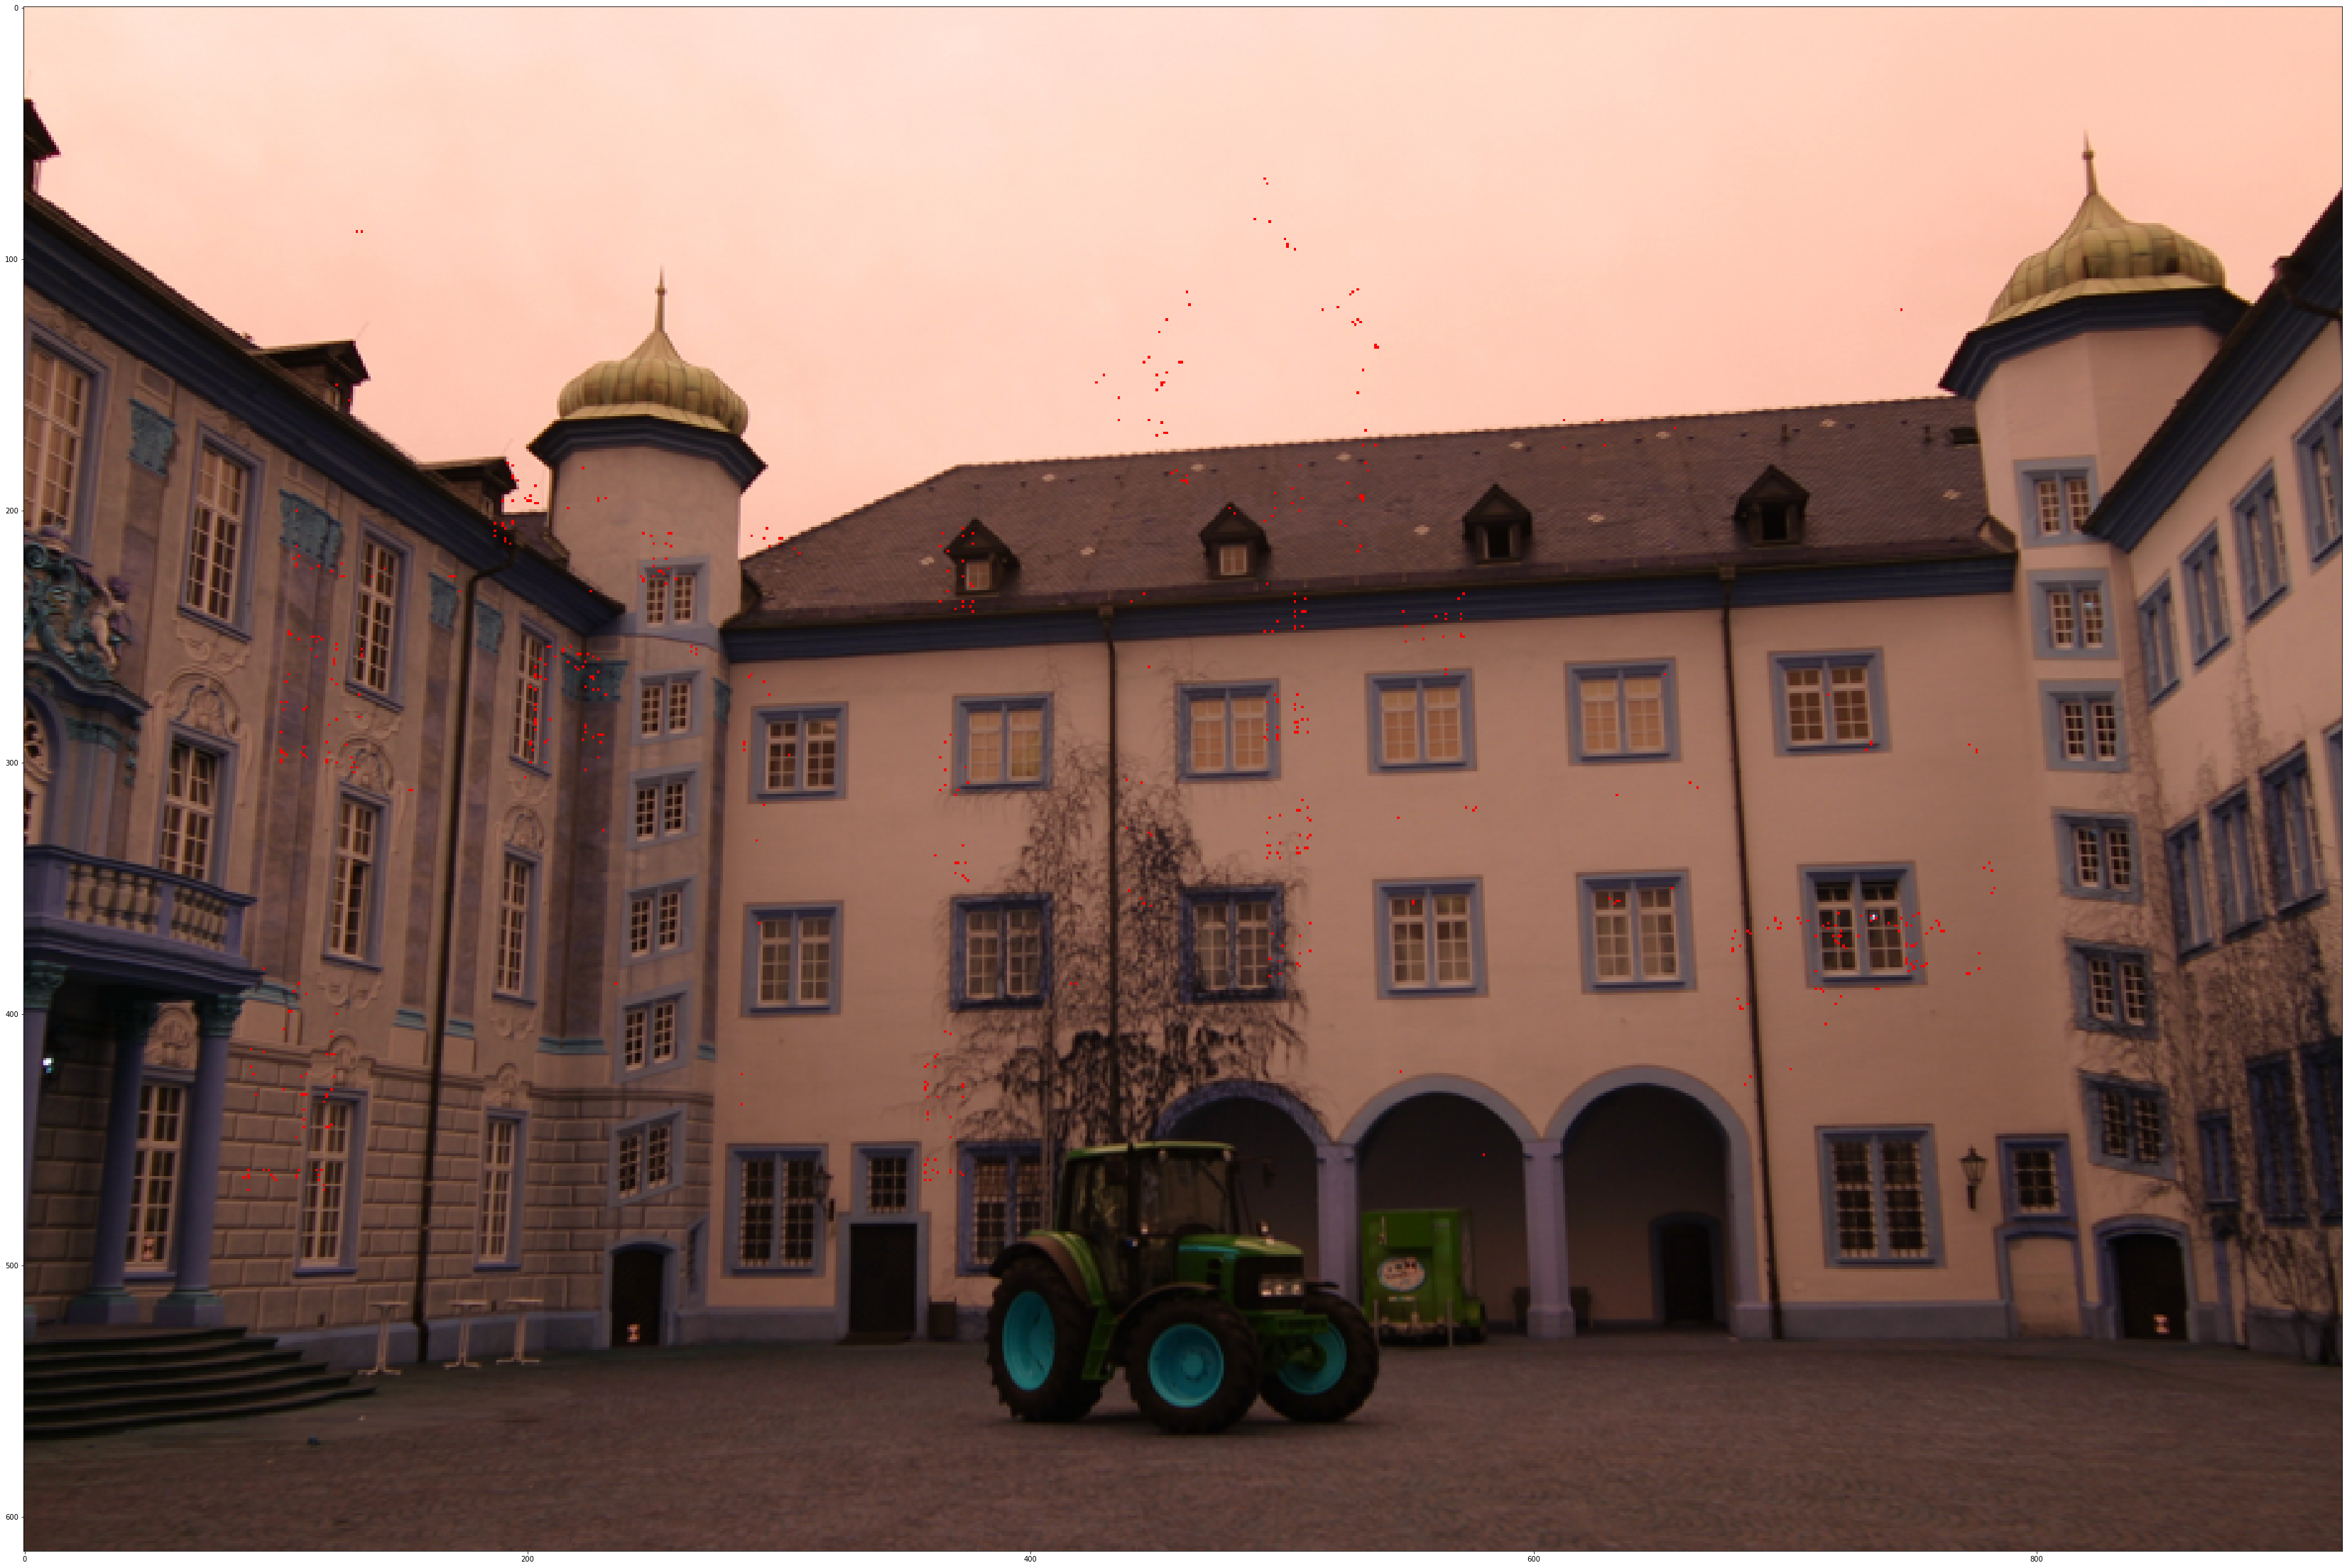

In [19]:
img_with_selected_points = copy.deepcopy(img1)
img_with_selected_points[x_img[:,1], x_img[:,0]] = [255,0,0]
plt.figure(figsize = (80,40))
plt.imshow(img_with_selected_points)

## 2.6 Reprojection Error

Once you selected a Camera, analyze the error of reprojecting the 3D space back to image coordinates. 

<span style='color:Green'>- Compute the reprojection errors  </span>
<span style='color:Green'>- Plot the histogram of reprojection errors, </span>
<span style='color:Green'>- Plot the mean reprojection error  </span>

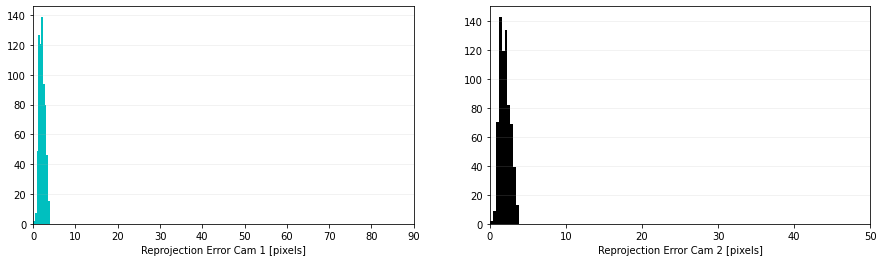

In [20]:
def reprojection_errors(x1, x2, P1, P2, X):
    """
    - x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
    - x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
    - P1: Camera 1 matrix
    - P2: Camera 2 matrix 
    - X: (4, `n_points`) homogenous coordinates of points in 3D space
    Compute the reprojection error from `X` to each of the camera's projective coordinates
    @return: (cam1_errors, cam2_errors)
    """
    
    x1_hat = P1@X
    x2_hat = P2@X
    
    x1_hat_euclid = x1_hat[:2,:] / x1_hat[-1,:]
    x2_hat_euclid = x2_hat[:2,:] / x2_hat[-1,:]
    x1_euclid = x1[:2,:] / x1[-1,:]
    x2_euclid = x2[:2,:] / x2[-1,:]
    
    cam1_errors = []
    cam2_errors = []
    
    for i in range(x1.shape[1]):
        cam1_errors.append(np.sqrt((x1_hat_euclid[0,i]-x1_euclid[0,i])**2 + (x1_hat_euclid[1,i]-x1_euclid[1,i])**2))
        cam2_errors.append(np.sqrt((x2_hat_euclid[0,i]-x2_euclid[0,i])**2 + (x2_hat_euclid[1,i]-x2_euclid[1,i])**2))
    

    return cam1_errors, cam2_errors

def plot_error_stats(cam1_errors, cam2_errors):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    
    ax1.hist(cam1_errors, color='c')
    ax1.grid(axis='y', alpha=0.2)
    ax1.set_xlabel("Reprojection Error Cam 1 [pixels]")
    ax1.set_xlim(0, 90)
    ax2.hist(cam2_errors, color='k')
    ax2.grid(axis='y', alpha=0.2)
    ax2.set_xlabel("Reprojection Error Cam 2 [pixels]")
    ax2.set_xlim(0, 50)


# Get projections with selected Camera 
X_pred = triangulate(x1, x2, P1, P2, [w, h])

cam1_errors, cam2_errors = reprojection_errors(x1, x2, P1, P2, X_pred)

plot_error_stats(cam1_errors, cam2_errors)

# **3. Depth map computation using local methods**

## 3.1 Vectorization (hint)

Vectorization is important to get efficient implementations that will allow you to run experiments in a reasonable amount of time

We will show you an example dummy computation using a naive implementation, a parallelized implementation and a vectorized implementation to see the importance of an efficient implementation and some ideas that you may reuse in the lab. This is just an example and there are different ways to vectorize, so I would suggest **reading about vectorization in python and finding your way.**


In [24]:
def add_row_calculation(row, N, height, width, padding, window_size):
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    for column in range(padding, width-padding):
        for i in range(window_size):
            for j in range(window_size):
                count += (left_img[row+i-padding, column+j-padding] -
                           right_img[row+i-padding, column+j-padding]) / N
    return count 

def dummy_computation(left_img, right_img, window_size):
    assert (window_size%2==1)
    assert (left_img.shape == right_img.shape)
    height, width = left_img.shape[0], left_img.shape[1]
    padding = window_size//2
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    for row in tqdm(range(padding, height-padding)):
        count += add_row_calculation(row, N=N, height=height, width=width, padding=padding, window_size=window_size)
    return count
    
def dummy_computation_parallelized(left_img, right_img, window_size, num_process=12):
    assert (window_size%2==1)
    assert (left_img.shape == right_img.shape)
    height, width = left_img.shape[0], left_img.shape[1]
    padding = window_size//2
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    with Pool(num_process) as pool:
        r = pool.map(partial(add_row_calculation, N=N, height=height, width=width, padding=padding, window_size=window_size),
                     range(padding, height-padding))
    return np.sum(r)

def dummy_computation_vectorized(left_img, right_img, window_size):
    left_view = sliding_window_view(left_img, (window_size, window_size))
    right_view = sliding_window_view(right_img, (window_size, window_size))
    return np.average(left_view - right_view)
    
left_img = cv2.imread("Data/scene1.row3.col3.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
right_img = cv2.imread("Data/scene1.row3.col4.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
window_size = 3
# num_process = 12
# t1 = time()
# print("Naive method result: \t\t", dummy_computation(left_img, right_img, window_size))
# t2 = time()
# # parallel_computation = DummyComputationParallized(left_img, right_img, window_size)
# # print("Parallelized method result: \t\t", parallel_computation.run())
# print("Parallelized method result: \t", dummy_computation_parallelized(left_img, right_img, window_size, num_process))
# t3 = time()
# print("Vectorized method result: \t", dummy_computation_vectorized(left_img, right_img, window_size))
# t4 = time()
# print(f"Naive method time: \t\t{t2-t1} seconds")
# print(f"Parallelized method time: \t{t3-t2} seconds")
# print(f"Vectorized method time: \t{t4-t3} seconds")

## 3.2 Disparity between a pair of rectified images

<span style='color:Green'> - Write a function called 'stereo_computation' that computes the disparity between a pair of rectified images </span>

Computational Efficiency is not a requirement but a plus.

![image](https://user-images.githubusercontent.com/8356912/151308788-854ad073-48b3-495a-af4c-dea99f4343d9.png)

**Optional:** You can also compute the depth map knowing *a priori* the focal length and baseline of the camera configuration (source: https://vision.middlebury.edu/stereo/data/scenes2014/)

In [197]:
def stereo_computation(left_img, right_img, min_disparity, max_disparity, win_size, method, color=False, proximity=False):
    """
    Computes the disparity map using stereo matching
    
    :param left_img: numpy array representing the left image
    :param right_img: numpy array representing the right image
    :param min_disparity: minimum disparity value
    :param max_disparity: maximum disparity value
    :param win_size: size of the sliding window
    :param method: method for computing the matching cost (e.g. SAD, SSD, etc.)
    :param method_kwargs: additional arguments for the matching cost method
    :return: numpy array representing the disparity map
    """
    # Get the shape of the images
    height, width = left_img.shape
    
    # Initialize the disparity map with zeros
    disparity_map = np.zeros((height, width), np.uint8)
    
    # Calculate the half size of the sliding window
    half_win = win_size // 2
    
    # Loop through each pixel in the left image
    for y in range(half_win, height - half_win):
        for x in range(half_win, width - half_win):
            # Extract the left window around the current pixel
            left_win = left_img[y-half_win:y + half_win + 1, x - half_win:x + half_win + 1]
            
            # Initialize minimum cost and best disparity to infinity and 0 respectively
            if method != 'ncc':
                min_cost = float('inf')
            else:
                min_cost = -float('inf')
                
            best_disparity = 0
            
            # Loop through the possible disparities
            for d in range(min_disparity, max_disparity + 1):
                # Skip if the right window goes out of the image bounds
                if x - d < half_win:
                    continue
                
                # Extract the right window around the current pixel
                right_win = right_img[y-half_win:y + half_win + 1, x - half_win - d:x + half_win - d + 1]
                
                
                weights = np.ones(left_win.shape)
                # Grouping by color
                if color == True:
                    diff_c = np.abs(left_win - right_win)
                    diff_c = np.exp(-(diff_c/14))
                    
                    weights *= diff_c
                
                # Grouping by proximity
                if proximity == True:
                    x_coords = np.arange(y-half_win, y+half_win+1, win_size)
                    y_coords = np.arange(x-half_win, x+half_win+1, win_size)

                    diff_g = np.linalg.norm(np.dstack((x_coords - y, y_coords - x)), axis=2)
                    diff_g = np.exp(-(diff_g/left_win.shape[0]))
                    
                    weights *= diff_g
                
                
                # Compute the matching cost between the left and right windows
                if method == 'ssd':
                    cost = sad(left_win, right_win, weights)
                elif method == 'sad':
                    cost = sad(left_win, right_win, weights)
                elif method == 'ncc':
                    cost = ncc(left_win, right_win, weights)
                
                # If the current cost is less than the minimum cost, update the minimum cost and best disparity
                if method != 'ncc' and cost < min_cost:
                    min_cost = cost
                    best_disparity = d
                elif method == 'ncc' and cost > min_cost:
                    min_cost = cost
                    best_disparity = d
                    
            
            # Set the best disparity for the current pixel in the disparity map
            disparity_map[y, x] = best_disparity
    
    return disparity_map


def sad(left_win, right_win, weights):
    return np.sum(weights * np.abs(left_win - right_win))

def ssd(left_win, right_win, weights):
    return np.sum(weights * np.square(left_win - right_win))

def ncc(left_win, right_win, weights):
    mean_left_win = np.mean(weights*left_win)
    mean_right_win = np.mean(weights*right_win)
    sigma_i1 = np.sqrt(np.sum(weights*np.square(left_win-mean_left_win)))
    sigma_i2 = np.sqrt(np.sum(weights*np.square(right_win-mean_right_win)))
    
    cost = np.sum(weights*(left_win-mean_left_win)*(right_win-mean_right_win)) / (sigma_i1*sigma_i2)
    return cost


im = stereo_computation(left_img, right_img, 0, 16, 9, 'sad', color=True, proximity=True)

(288, 384)


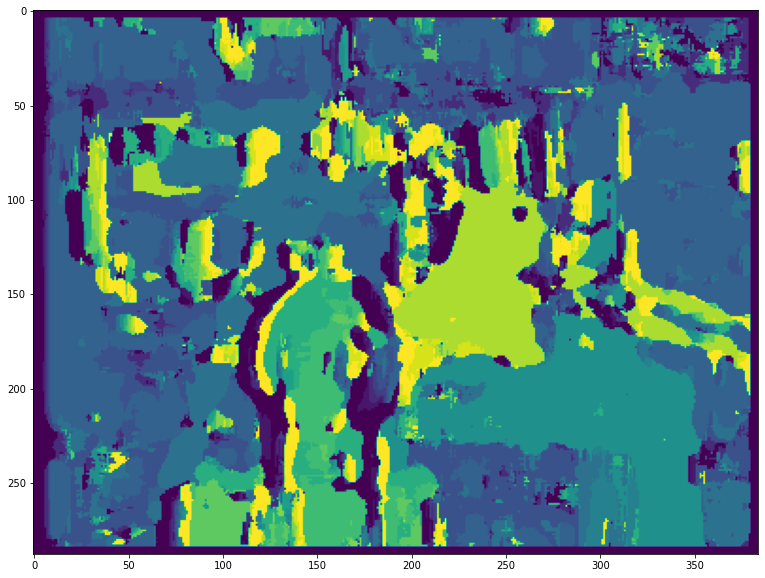

In [198]:
print(im.shape)

plt.imshow(im)
plt.show()

## 3.3 Sum of Squared Differences Cost
__Data images: 'scene1.row3.col3.ppm','scene1.row3.col4.ppm'  
Disparity ground truth: 'truedisp.row3.col3.pgm'__

In this part we ask to implement only the SSD cost


<span style='color:Green'> - Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31) and the Mean Square Error (MSE). Comment the results.  </span>

 **Note 1**: Use grayscale images  
 
 **Note 2**: For this first set of images use 0 as minimum disparity and 16 as the the maximum one.

![image](https://user-images.githubusercontent.com/8356912/151308710-679e9b2c-8dfc-48da-8378-a844b10ef4f7.png)

In [ ]:
window_sizes = [3,9,21,31]

for win_size in window_sizes:
    im_stereo = stereo_computation(left_img, right_img, 0, 16, win_size, 'ssd', color=False, proximity=False)

## 3.4 Normalized  Cross Correlation Cost

<span style='color:Green'> - Complete the previous function by adding the implementation of the NCC cost. </span>

<span style='color:Green'>  Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31). Comment the results. </span>



## 3.5 Apply to facade images

Data images: '0001_rectified_s.png','0002_rectified_s.png'

<span style='color:Green'> - Test the functions implemented in the previous section with the facade images. Try different matching costs and window sizes and comment the results. </span>
    
Notice that in this new data the minimum and maximum disparities may change.

## 3.6 Adaptive support weights


<span style='color:Green'> - Modify the 'stereo_computation' so that you can use adaptive support weights considering both **proximity** and **similarity**</span>

- Use the original [Exponential](https://ieeexplore.ieee.org/document/1597121#:~:text=Abstract%3A%20We%20present%20a%20new,to%20reduce%20the%20image%20ambiguity.) filters and [Bilateral](https://www.ipol.im/pub/art/2015/123/) Filtering. How are they different?
- How are the support weights adaptive? Plot the support weights for exemplary cases that illustrate the adaptive nature.
- Implement the support weights for color and black and white images. What similarity metric for black and white can you use? 
- Make a small comparison of the effect of the support weights parameters, and compare them to the previous results.
   
Reference paper: Yoon and Kweon, "Adaptive Support-Weight Approach for Correspondence Search", IEEE PAMI 2006

![image](https://user-images.githubusercontent.com/8356912/151323058-04124700-7c77-46bc-8b25-6ac1473300ce.png)
